Refferrance::

Articles for Power Oscillator
    [Power Oscillator](http://hcburger.com/blog/poweroscillator/index.html)
    
    [Bitcoin’s natural long-term power-law corridor of growth]
    (http://medium.com/quantodian-publications/bitcoins-natural-long-term-power-law-corridor-of-growth-649d0e9b3c94)



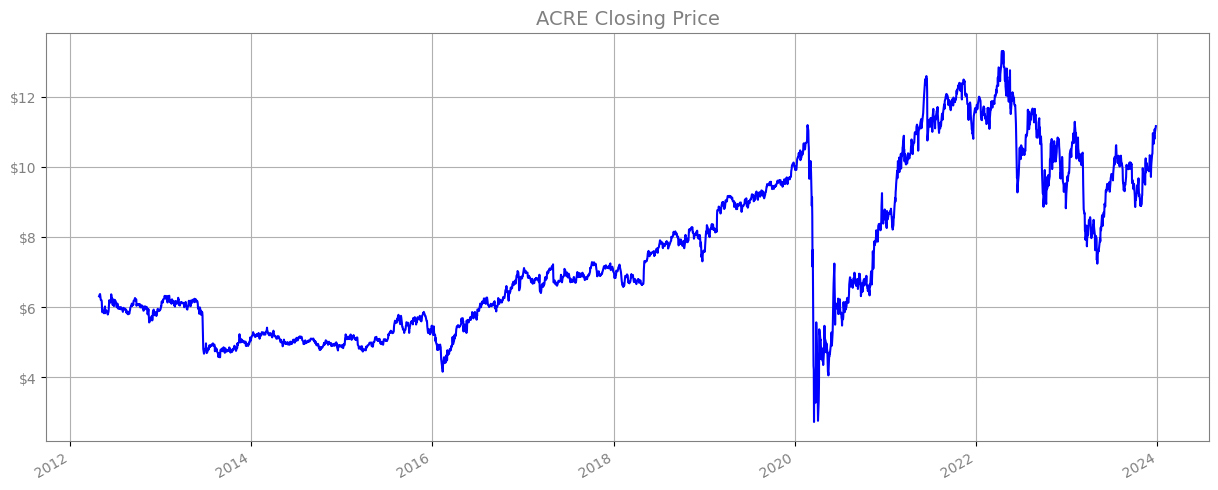

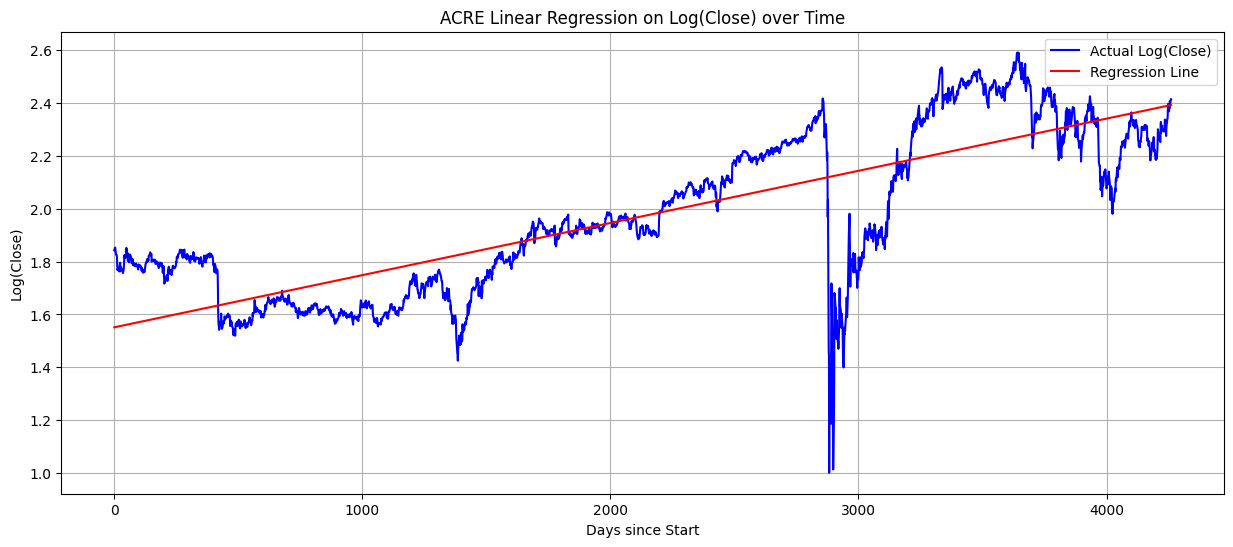

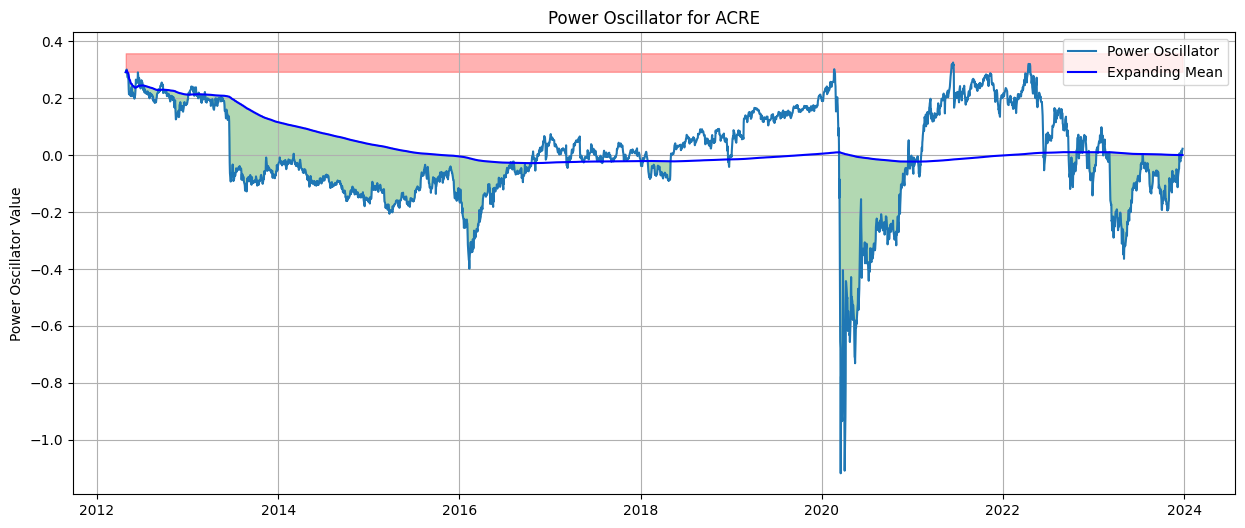

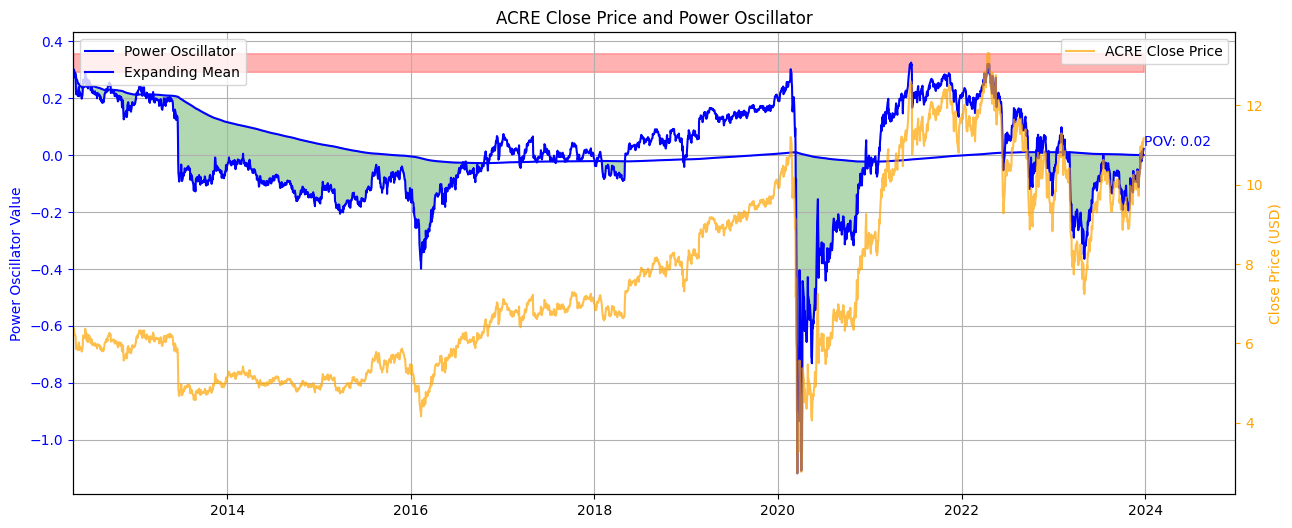

In [82]:
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
# set style to default 
plt.style.use('default')    

def get_stock_data(ticker, interval="1d"):
    ticker = yf.Ticker(ticker)
    data = ticker.history(period="max", interval=interval)
    return data

    # Custom formatter function

def currency_formatter(x, pos):
    return f'${x:,.0f}'

def basic_plot(symbol, data_column):
    plt.figure(figsize=(15,6))
    ax = data_column.plot(color='blue')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.yaxis.set_major_formatter(currency_formatter)
    # set the title
    ax.set_title(f'{symbol} Closing Price', fontsize=14, color='grey')
    # set the color
    ax.tick_params(labelcolor='grey')
    # set the spine color 
    spine_colors = {'left': 'grey', 'right': 'grey', 'top': 'grey', 'bottom': 'grey'}
    for spine, color in spine_colors.items():
        ax.spines[spine].set_color(color)
    ax.grid(True)    
    plt.show()

def get_log_linear_regression_stock(ticker_data):
    # Reset the index and prepare data for regression
    ticker_data.reset_index(inplace=True)
    ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])
    ticker_data['Days'] = (ticker_data['Date'] - ticker_data['Date'].min()).dt.days
    ticker_data['LogClose'] = np.log(ticker_data['Close'])
    # Linear regression model
    model = LinearRegression()
    model.fit(ticker_data[['Days']], ticker_data['LogClose'])
    return ticker_data, model

def linear_regression_plot(symbol, ticker_data, model): 
    # Predicting and adding to dataframe
    ticker_data['PredictedLogClose'] = model.predict(ticker_data[['Days']])
    # Plotting the original data and regression line
    plt.figure(figsize=(15, 6))
    plt.plot(ticker_data['Days'], ticker_data['LogClose'], color='blue', label='Actual Log(Close)')
    plt.plot(ticker_data['Days'], ticker_data['PredictedLogClose'], color='red', label='Regression Line')
    # Adding labels, title, and grid
    plt.xlabel('Days since Start')
    plt.ylabel('Log(Close)')
    plt.title(f'{symbol} Linear Regression on Log(Close) over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def power_law_oscillator_plot(symbol, ticker_data, model):
    # Predicting and calculating deviations
    ticker_data['PredictedLogClose'] = model.predict(ticker_data[['Days']])
    ticker_data['Deviation'] = ticker_data['LogClose'] - ticker_data['PredictedLogClose']
    # Identifying the peak value in the power oscillator
    peak_value = ticker_data['Deviation'].max()
    # Setting a range around the peak value (for example, a certain percentage of the peak value)
    value_range = 0.1 * peak_value  # 10% of the peak value
    lower_bound = peak_value - value_range
    upper_bound = peak_value + value_range
    # calculate the cumulative mean of the deviations
    ticker_data['Expanding_Mean'] = ticker_data['Deviation'].expanding().mean()
    # Plotting with horizontal shaded area around the peak value
    plt.figure(figsize=(15, 6))
    plt.plot(ticker_data['Date'], ticker_data['Deviation'], label='Power Oscillator')
    plt.plot(ticker_data['Date'], ticker_data['Expanding_Mean'], label='Expanding Mean', color='blue')
    plt.fill_between(ticker_data['Date'], lower_bound, upper_bound, color='red', alpha=0.3)
    plt.fill_between(ticker_data['Date'], ticker_data['Deviation'], ticker_data['Expanding_Mean'], where=(ticker_data['Deviation'] <= ticker_data['Expanding_Mean']), color='green', alpha=0.3)
    plt.xlabel('')
    plt.ylabel('Power Oscillator Value')
    plt.title(f'Power Oscillator for {symbol}')
    plt.legend()
    plt.grid(True)
    plt.show()
     
def combo_close_power_law_plot(symbol, ticker_data, model):
    # Create a figure and a set of subplots
    plt.figure(figsize=(15, 6))
    # Predicting and calculating deviations
    ticker_data['PredictedLogClose'] = model.predict(ticker_data[['Days']])
    ticker_data['Deviation'] = ticker_data['LogClose'] - ticker_data['PredictedLogClose']
    # Identifying the peak value in the power oscillator
    peak_value = ticker_data['Deviation'].max()
    # Setting a range around the peak value (for example, a certain percentage of the peak value)
    value_range = 0.1 * peak_value  # 10% of the peak value
    lower_bound = peak_value - value_range
    upper_bound = peak_value + value_range
    # calculate the cumulative mean of the deviations
    ticker_data['Expanding_Mean'] = ticker_data['Deviation'].expanding().mean()
    # Plotting the Close Price on the primary y-axis
    ax1 = plt.gca()  # Get the current axes
    ax1.set_title(f'{symbol} Close Price and Power Oscillator')
    ax1.grid(True)
    ax1.plot(ticker_data['Date'], ticker_data['Deviation'], label='Power Oscillator', color='blue')
    ax1.fill_between(ticker_data['Date'], lower_bound, upper_bound, color='red', alpha=0.3)
    ax1.plot(ticker_data['Date'], ticker_data['Expanding_Mean'], label='Expanding Mean', color='blue')
    ax1.fill_between(ticker_data['Date'], ticker_data['Deviation'], ticker_data['Expanding_Mean'], where=(ticker_data['Deviation'] <= ticker_data['Expanding_Mean']), color='green', alpha=0.3)
    ax1.set_ylabel('Power Oscillator Value', color='blue')
    ax1.tick_params('y', colors='blue')
    # add an annotation for the current Deviation value
    ax1.annotate(f'POV: {ticker_data["Deviation"].iloc[-1]:.2f}', xy=(ticker_data['Date'].max(), ticker_data['Deviation'].iloc[-1]), xytext=(ticker_data['Date'].max(), ticker_data['Deviation'].iloc[-1] + 0.5 * ticker_data['Deviation'].iloc[-1]), color='blue')
    # Creating a second y-axis for the power oscillator
    ax2 = ax1.twinx()
    ax2.plot(ticker_data['Date'], ticker_data['Close'], label=f'{symbol} Close Price', color='orange', alpha=0.7)
    ax2.set_xlabel('')
    ax2.set_ylabel('Close Price (USD)', color='orange')
    ax2.tick_params('y', colors='orange')
    # Adding legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # Determine the minimum and maximum dates
    min_date = ticker_data['Date'].min()
    max_date = ticker_data['Date'].max()
    # Add buffer to the start and end dates (e.g., 1 year days)
    buffer_days = pd.Timedelta(days=365)
    start_date = min_date
    end_date = max_date + buffer_days
    # Setting the limits of the x-axis
    ax1.set_xlim(start_date, end_date)
    ax2.set_xlim(start_date, end_date)
    # Show the plot
    plt.show()
    
def cumulative_dividends_plot(ticker, data):
    pass
    # # plot the Cumulative_Dividends using figure and axis objects
    # fig, ax = plt.subplots(figsize=(15,6))
    # ax.plot(dividends_data['Cumulative_Dividends'], color='blue', alpha=0.7)
    # # set the x-axis label
    # ax.set_xlabel('')
    # # set the y-axis label
    # ax.set_ylabel('')
    # # set the color
    # ax.tick_params(axis='y', labelcolor='blue')
    # # set the title
    # ax.set_title(f'{tickerSymbol} Cumulative Dividends', fontsize=14, color='grey')
    # # rotate the x-axis ticks
    # ax.tick_params(axis='x', rotation=45, colors='grey')
    # # show the plot
    # plt.show()

def dividends_payout_plot(ticker, data, initial_investment):
    # Number of shares bought at the beginning (using the opening price of the first day)
    initial_shares = initial_investment / data.iloc[0]['Open']
    # create a column that calculates the payout amount for each dividend
    data['Payout'] = data['Dividends'] * initial_shares
    # Ensure the div_data dataframe only contains records with payouts
    div_data = data[data['Payout'] > 0]
    # Set the default Plotly template
    px.defaults.template = "plotly_dark"
    # Create the bar plot
    fig = px.bar(div_data, x=div_data['Date'], y='Payout', title=f'{ticker} Dividends Payout', color='Payout', color_continuous_scale='Purples')
    # increase bar width
    fig.update_traces(marker_line_width=0, width=2.5)
    # Display the plot
    fig.show()

def run_app():
    ticker = input("Enter the stock ticker: ").upper()
    data = get_stock_data(ticker)
    basic_plot(ticker, data["Close"])
    ticker_data, model = get_log_linear_regression_stock(data)
    linear_regression_plot(ticker, ticker_data, model)
    power_law_oscillator_plot(ticker, ticker_data, model)
    combo_close_power_law_plot(ticker, ticker_data, model)
    initial_investment = input("Enter the Initial Investment Amount: ")
    initial_investment = float(initial_investment)
    dividends_payout_plot(ticker, data, initial_investment)


if __name__ == "__main__":
    run_app()